In [2]:
# Predict Bicycle Traffic
# url = 'https://raw.githubusercontent.com/jakevdp/bicycle-data/main'
# !curl -O {url}/FremontBridge.csv
# !curl -O {url}/SeattleWeather.csv
path = "/__PROJECTS/aa_CommonData/ml/"
import pandas as pd 
counts = pd.read_csv(path + 'FremontBridge.csv',
    index_col='Date', parse_dates=True)
weather = pd.read_csv(path + 'SeattleWeather.csv',
    index_col='DATE', parse_dates=True)

counts.head()

/tmp/ipykernel_557956/1889895321.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  counts = pd.read_csv(path + 'FremontBridge.csv',


,"Fremont Bridge Sidewalks, south of N 34th St","Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk","Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk"
Date,,,
2012-10-02 13:00:00,55.0,7.0,48.0
2012-10-02 14:00:00,130.0,55.0,75.0
2012-10-02 15:00:00,152.0,81.0,71.0
2012-10-02 16:00:00,278.0,167.0,111.0
2012-10-02 17:00:00,563.0,393.0,170.0


In [3]:
weather.head()

,STATION,NAME,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,...,WT04,WT05,WT08,WT09,WT13,WT14,WT16,WT17,WT18,WT22
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",10.51,NaN,NaN,0.00,0.0,0.0,NaN,55,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2012-01-02,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",10.07,NaN,NaN,0.43,0.0,0.0,NaN,51,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2012-01-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",5.14,NaN,NaN,0.03,0.0,0.0,NaN,53,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2012-01-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",10.51,NaN,NaN,0.80,0.0,0.0,NaN,54,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2012-01-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",13.65,NaN,NaN,0.05,0.0,0.0,NaN,48,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [13]:
counts = counts[counts.index < "2020-01-01"]
weather = weather[weather.index < "2020-01-01"]

In [14]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

In [15]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [16]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2020')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [17]:
%matplotlib inline 
import matplotlib.pyplot as plt 
plt.style.use("seaborn-whitegrid")
import numpy as np 

/tmp/ipykernel_557956/2990274855.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


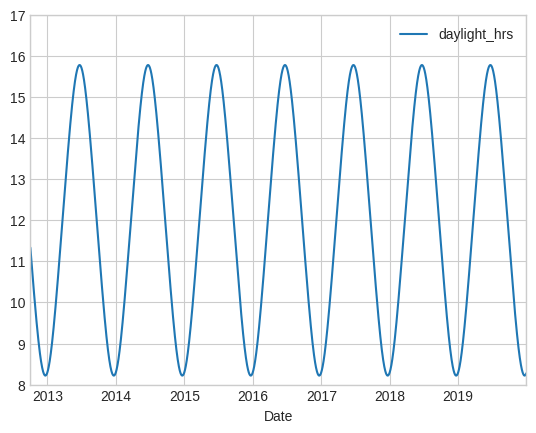

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.Timestamp(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude)) 
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = daily.index.map(hours_of_daylight)
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)
plt.show()

In [27]:
weather['Temp (F)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])
weather['Rainfall (in)'] = weather['PRCP']
weather['dry day'] = (weather['PRCP'] == 0).astype(int)
daily = daily.join(weather[['Rainfall (in)', 'Temp (F)', 'dry day']])

In [29]:
daily["annual"] = (daily.index - daily.index[0]).days / 356.

In [30]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Rainfall (in),Temp (F),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-02,3876.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.335681,0.0,57.0,1,0.000000
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,56.0,1,0.002809
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,56.5,1,0.005618
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,59.5,1,0.008427
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,60.5,1,0.011236


In [31]:
# Drop any rows with null values 
from sklearn.linear_model import LinearRegression


daily.dropna(axis=0, how="any", inplace=True)
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun',
'holiday', 'daylight_hrs', 'Rainfall (in)',
'dry day', 'Temp (F)', 'annual']
X = daily[column_names]
y = daily["Total"]

model = LinearRegression(fit_intercept=False)
model.fit(X,y)
daily["predicted"] = model.predict(X)

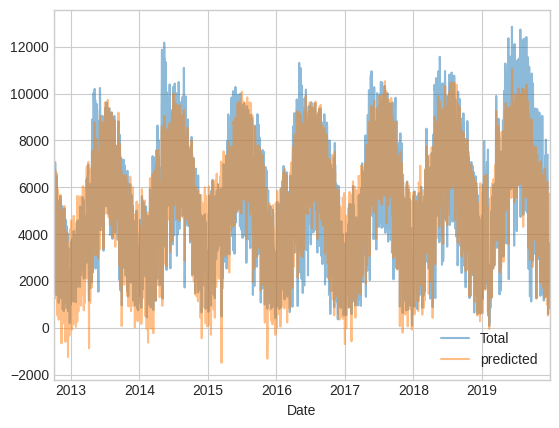

In [32]:
daily[['Total', 'predicted']].plot(alpha=0.5);

In [33]:
params = pd.Series(model.coef_, index=X.columns)
params 

Mon             -1659.031859
Tue             -1442.936409
Wed             -1485.433417
Thu             -1744.420708
Fri             -2422.100854
Sat             -5222.444347
Sun             -5401.607278
holiday         -2502.207217
daylight_hrs      205.129795
Rainfall (in)   -1393.999681
dry day          1053.452853
Temp (F)           89.408200
annual            159.213700
dtype: float64

In [35]:
from sklearn.utils import resample 
np.random.seed(1)

err = np.std([model.fit(*resample(X,y)).coef_ for i in range(1000)], 0)

In [36]:
print(pd.DataFrame({"effect":params.round(0), "uncertainty":err.round(0)}))

               effect  uncertainty
Mon           -1659.0        140.0
Tue           -1443.0        140.0
Wed           -1485.0        139.0
Thu           -1744.0        138.0
Fri           -2422.0        136.0
Sat           -5222.0        132.0
Sun           -5402.0        135.0
holiday       -2502.0        201.0
daylight_hrs    205.0         13.0
Rainfall (in) -1394.0         94.0
dry day        1053.0         51.0
Temp (F)         89.0          3.0
annual          159.0         11.0
